## <mark> Continuous Bag of Words

Every word is assigned a vector.
We try to fit neighbouring words in the window to the central word.

### Imports

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt

### Data

In [1]:
sentences = """Canada is a country in North America. 
Its ten provinces and three territories extend 
from the Atlantic Ocean to the Pacific Ocean and northward into the Arctic Ocean, 
making it the world's second-largest country by total area, with the world's longest coastline."""

### Clean Data

In [3]:
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)
sentences

'Canada is a country in North America Its ten provinces and three territories extend from the Atlantic Ocean to the Pacific Ocean and northward into the Arctic Ocean making it the world s second largest country by total area with the world s longest coastline '

In [4]:
# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()
sentences

'Canada is country in North America Its ten provinces and three territories extend from the Atlantic Ocean to the Pacific Ocean and northward into the Arctic Ocean making it the world second largest country by total area with the world longest coastline'

In [5]:
# lower all characters
sentences = sentences.lower()
sentences

'canada is country in north america its ten provinces and three territories extend from the atlantic ocean to the pacific ocean and northward into the arctic ocean making it the world second largest country by total area with the world longest coastline'

### vocabulary

In [6]:
words = sentences.split()

In [7]:
vocab = set(words)

In [10]:
vocab_size = len(vocab)
print(len(vocab))

embed_dim = 10
context_size = 2

33


### Dictionaries for vocab

In [11]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
word_to_ix

{'making': 0,
 'by': 1,
 'ocean': 2,
 'country': 3,
 'extend': 4,
 'territories': 5,
 'world': 6,
 'is': 7,
 'from': 8,
 'northward': 9,
 'the': 10,
 'second': 11,
 'area': 12,
 'in': 13,
 'total': 14,
 'it': 15,
 'north': 16,
 'largest': 17,
 'pacific': 18,
 'longest': 19,
 'arctic': 20,
 'america': 21,
 'three': 22,
 'canada': 23,
 'to': 24,
 'its': 25,
 'ten': 26,
 'and': 27,
 'into': 28,
 'coastline': 29,
 'atlantic': 30,
 'provinces': 31,
 'with': 32}

In [14]:
ix_to_word = {i: word for i, word in enumerate(vocab)}

### Data bags

In [15]:
print(words)

['canada', 'is', 'country', 'in', 'north', 'america', 'its', 'ten', 'provinces', 'and', 'three', 'territories', 'extend', 'from', 'the', 'atlantic', 'ocean', 'to', 'the', 'pacific', 'ocean', 'and', 'northward', 'into', 'the', 'arctic', 'ocean', 'making', 'it', 'the', 'world', 'second', 'largest', 'country', 'by', 'total', 'area', 'with', 'the', 'world', 'longest', 'coastline']


In [16]:
data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
    
print(data[:1])

[(['canada', 'is', 'in', 'north'], 'country')]


### Embeddings

In [21]:
vocab_size = len(vocab)
embed_dim = 10

embeddings =  np.random.random_sample((vocab_size, embed_dim))
# np.random.random_sample # Return random floats in the half-open interval [0.0, 1.0)

print(embeddings.shape)
embeddings

(33, 10)


array([[0.8175968 , 0.87943052, 0.41856993, 0.11690787, 0.11593224,
        0.98739287, 0.15458912, 0.36984107, 0.71977256, 0.78904655],
       [0.61917216, 0.92077002, 0.6215365 , 0.06413199, 0.30953235,
        0.81263181, 0.91998709, 0.11887873, 0.96507578, 0.6090109 ],
       [0.40840095, 0.40917227, 0.40420669, 0.83122772, 0.26271051,
        0.02782673, 0.91559529, 0.14984849, 0.15832209, 0.52659874],
       [0.9858313 , 0.77874087, 0.71796985, 0.66435336, 0.74509188,
        0.85010792, 0.51781306, 0.37489027, 0.25116166, 0.68293162],
       [0.51262766, 0.40536333, 0.68350078, 0.76649417, 0.04633286,
        0.93975756, 0.71530574, 0.50312058, 0.20731707, 0.43549446],
       [0.67804857, 0.55641883, 0.57830063, 0.05490186, 0.92837343,
        0.93048098, 0.64983305, 0.34051296, 0.64830024, 0.66000005],
       [0.96456257, 0.50980442, 0.669501  , 0.91938682, 0.94612973,
        0.91225676, 0.12926265, 0.71954457, 0.67183075, 0.58733488],
       [0.15210959, 0.26510371, 0.2201875

### Linear Model

In [22]:
# y = mx + theta
def linear(m, theta):
    w = theta
    return m.dot(w)

### Log softmax + NLLloss = Cross Entropy

In [30]:
def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

In [31]:
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

In [32]:
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- out + softmax) / logits.shape[0]

### Forward function

In [33]:
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)
    return m, n, o

### Backward function

In [34]:
def backward(preds, theta, target_idxs):
    m, n, o = preds
    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)
    return dw

### Optimize function

In [35]:
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

### Training function

In [36]:
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))
theta

array([[-0.39258048,  0.97369652, -0.07154428, ..., -0.06634685,
         0.86805   , -0.08847551],
       [ 0.94173448,  0.30912667, -0.73046244, ..., -0.87542436,
         0.4535658 , -0.53203673],
       [ 0.05451803, -0.56933751,  0.74802829, ..., -0.37563336,
        -0.73767917,  0.49479838],
       ...,
       [ 0.23187637,  0.5805052 , -0.69568239, ...,  0.22804983,
         0.01471883,  0.21707486],
       [-0.28561468,  0.40580853, -0.58697418, ..., -0.41463447,
         0.2805638 , -0.34786746],
       [-0.57365642,  0.98959971, -0.74492637, ...,  0.67905934,
         0.47346505, -0.39591675]])

In [37]:
data[:2]

[(['canada', 'is', 'in', 'north'], 'country'),
 (['is', 'country', 'north', 'america'], 'in')]

In [38]:
epoch_losses = {}

for epoch in range(80):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)
        
     
    epoch_losses[epoch] = losses

### Plot loss/epoch

Text(0, 0.5, 'Losses')

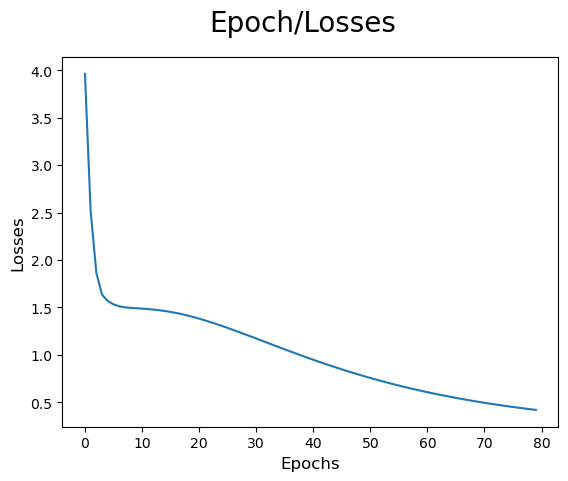

In [39]:
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

### Predict function

In [40]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]
    
    return word

In [52]:
# (['canada', 'is', 'in', 'north'], 'country')
# (['its', 'ten', 'and', 'three'], 'provinces')
predict(['canada', 'ten', 'and', 'atlantic'])

'provinces'

In [49]:
data

[(['canada', 'is', 'in', 'north'], 'country'),
 (['is', 'country', 'north', 'america'], 'in'),
 (['country', 'in', 'america', 'its'], 'north'),
 (['in', 'north', 'its', 'ten'], 'america'),
 (['north', 'america', 'ten', 'provinces'], 'its'),
 (['america', 'its', 'provinces', 'and'], 'ten'),
 (['its', 'ten', 'and', 'three'], 'provinces'),
 (['ten', 'provinces', 'three', 'territories'], 'and'),
 (['provinces', 'and', 'territories', 'extend'], 'three'),
 (['and', 'three', 'extend', 'from'], 'territories'),
 (['three', 'territories', 'from', 'the'], 'extend'),
 (['territories', 'extend', 'the', 'atlantic'], 'from'),
 (['extend', 'from', 'atlantic', 'ocean'], 'the'),
 (['from', 'the', 'ocean', 'to'], 'atlantic'),
 (['the', 'atlantic', 'to', 'the'], 'ocean'),
 (['atlantic', 'ocean', 'the', 'pacific'], 'to'),
 (['ocean', 'to', 'pacific', 'ocean'], 'the'),
 (['to', 'the', 'ocean', 'and'], 'pacific'),
 (['the', 'pacific', 'and', 'northward'], 'ocean'),
 (['pacific', 'ocean', 'northward', 'into']

### Accuracy

In [53]:
def accuracy():
    wrong = 0

    for context, target in data:
        if(predict(context) != target):
            wrong += 1
            
    return (1 - (wrong / len(data)))

In [54]:
accuracy()

1.0